# 5장. 차원 축소를 사용한 데이터 압축

특성 추출 - 데이터 압축하기:  
* 주성분 분석 - 비지도 데이터 압축
* 선형 판별 분석 - 지도 방식 차원 축소 기법
* 커널 PCA - 비선형 차원 축소

## 5.1 주성분 분석을 통한 비지도 차원 축소

새로운 특성 공간으로 데이터를 변환하거나 투영  
대부분의 관련 있는 정보를 유지하면서 데이터를 압축  
특히 규제가 없는 모델로 작업할 때 차원의 저주 문제를 감소시켜 예측 성능을 향상

### 5.1.1 주성분 분석의 주요 단계

*USAGE)* exploratory data analysis, 주식 거래 시장의 잡음 제거, 게놈 데이터나 유전자 발현 분석 등에 이용  
PCA는 고차원 데이터에서 분산이 가장 큰 방향을 찾고 좀 더 작거나 같은 수의 차원을 갖는 새로운 부분 공간으로 이를 투영  
차원을 축소하기 위해 $d\times k$ 차원의 변환 행렬 $\mathbf{W}$ 를 만듦  
원본 $d$ 차원 데이터를 새로운 $k$ 차원의 부분 공간으로 변환하여 만들어진 첫번재 주성분이 가장 큰 분산을 가짐  

이를 정리하면:  
1) $d$ 차원 데이터셋을 *표준화 전처리*
2) *공분산 행렬*을 만듦
3) 공분산 행렬을 *고유 벡터*와 *고유값*으로 분해
4) 고유값을 내림차순으로 정렬하고 그에 해당하는 고유 벡터의 순위를 매김
5) 고유값이 가장 큰 $k$ 개의 고유 벡터를 선택
6) 최상위 $k$ 개의 고유 벡터로 *투영 행렬* $\mathbf{W}$ 를 만듦
7) 투영 행렬을 이용하여 새로운 차원의 특성 부분 공간으로 변환  

### 5.1.2 주성분 추출 단계

1번 과정부터 4번 과정까지

In [2]:
# Wine 데이터셋 로드
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

In [3]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     stratify=y,
                     random_state=0)

# 특성을 표준화 전처리
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

두 특성 $x_j$와 $x_k$ 사이의 공분산  
$$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^n (x_j^{(i)}-\mu_j)(x_k^{(i)}-\mu_k)$$

In [4]:
# 공분산 행렬 구하기 -> 고유 벡터와 고유값 쌍 구하기
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\n고유값 \n%s' % eigen_vals)


고유값 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


### 5.1.3 총 분산과 설명된 분산

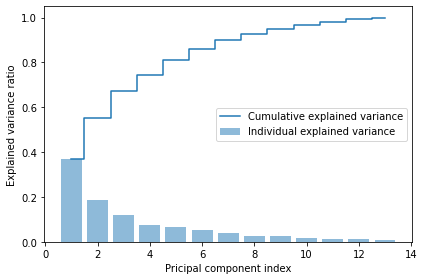

In [5]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
           sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Pricipal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 5.1.4 특성 변환

5번 과정에서 7번 마지막까지  

* 고유값이 가장 큰 고유 벡터를 선택
* 최상위 고유 벡터로 투영 행렬을 만듦
* 투영 행렬을 사용해서 새로운 차원의 특성 부분 공간으로 변환


In [6]:
# (고유값, 고유벡터) 튜플의 리스트를 만듦
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]
# 내림차순으로 튜플을 정렬
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [7]:
# 고유벡터로부터 투영행렬 만들기
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('투영 행렬 W:\n', w)

투영 행렬 W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [8]:
# 샘플을 PCA 부분 공간으로 투영
X_train_pca = X_train_std.dot(w)

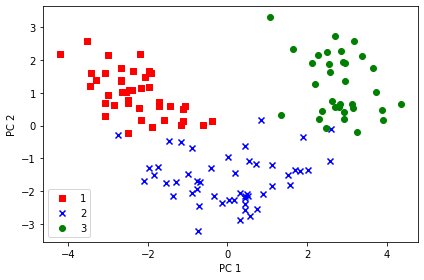

In [9]:
# 산점도로 시각화
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### 5.1.5 사이킷런의 주성분 분석

`PCA` 클래스 이용하여 구현

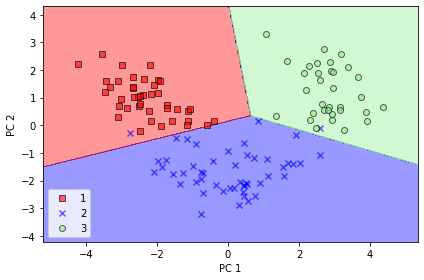

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import plot_decision_regions as pltreg

# PCA 변환기와 로지스틱 회기 추정기를 초기화
pca = PCA(n_components=2)
lr = LogisticRegression(random_state=1)

# 차원 축소
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# 축소된 데이터셋으로 로지스틱 회귀 모델 훈련
lr.fit(X_train_pca, y_train)
pltreg.plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

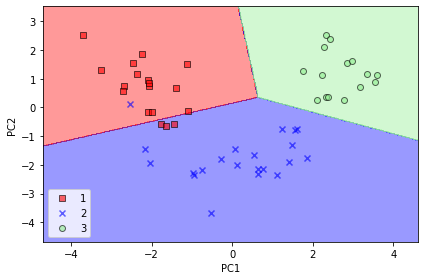

In [11]:
pltreg.plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [12]:
# 전체 주성분의 설명된 분산 비율을 보고 싶다면
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

In [13]:
pca = PCA(n_components=0.95)
pca.fit(X_train_std)
print('주성분 개수: ', pca.n_components_)
print('설명된 분산 비율: ', np.sum(pca.explained_variance_ratio_))

주성분 개수:  10
설명된 분산 비율:  0.9662714406558743


In [14]:
pca = PCA(n_components='mle')
pca.fit(X_train_std)
print('주성분 개수: ', pca.n_components_)
print('설명된 분산 비율: ', np.sum(pca.explained_variance_ratio_))

주성분 개수:  9
설명된 분산 비율:  0.9499753029186233


In [15]:
# 데이터 일부를 사용해 반복적으로 훈련
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=9)
for batch in range(len(X_train_std)//25 + 1):
    X_batch = X_train_std[batch*25:(batch+1)*25]
    ipca.partial_fit(X_batch)
print('주성분 개수: ', ipca.n_components_)
print('설명된 분산 비율: ', np.sum(ipca.explained_variance_ratio_))

주성분 개수:  9
설명된 분산 비율:  0.9478392700446663


## 5.2 선형 판별 분석을 통한 지도 방식의 데이터 압축

일반적인 개념은 PCA와 유사  
LDA 목표는 클래스를 최적으로 구분할 수 있는 특성 부분 공간을 찾는 것

### 5.2.1 주성분 분석 vs 선형 판별 분석

선형 판별 분석은 지도 학습 알고리즘  
데이터가 정규 분포라고 가정  
클래스가 동일한 공분산 행렬을 가지고 훈련 샘플은 서로 통계적으로 독립적이라고 가정

### 5.2.2 선형 판별 분석의 내부 동작 방식

1. $d$ 차원의 데이터셋을 표준화 전처리
2. 각 클래스에 대해 $d$ 차원의 평균 벡터를 계산
3. 클래스 간의 산포 행렬 ($\mathbf{S}_B$), 클래스 내 산포 행렬 ($\mathbf{S}_W$)을 구성
4. $\mathbf{S}_W^{-1}\mathbf{S}_B$ 행렬의 고유 벡터와 고유값 계산
5. 고유값을 내림차순으로 정렬하여 순서를 메김
6. 고유값이 가장 큰 $k$개의 고유 벡터를 선택하여 변환 행렬 $\mathbf{W}$를 구성
7. 샘플을 새로운 특성 부분 공간으로 투영

클레스 레이블 별로 데이터를 나누어 평균을 구함

### 5.2.3 산포 행렬 계산

평균 벡터 ($\mathbf{m}_i$) = 클래스 $i$의 샘플에 대한 특성의 평균값 $\mu_m$을 저장

In [16]:
# 평균 벡터 계산
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(
        X_train_std[y_train==label], axis=0
    ))
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [17]:
# 클래스 내 산포 행렬 계산
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('클래스 내의 산포 행렬: %s x %s' % (
    S_W.shape[0], S_W.shape[1]
))

클래스 내의 산포 행렬: 13 x 13


In [18]:
# 산포 행렬 계산 시 클래스 레이블이 균등하게 분포되어 있다고 가정
print('클래스 레이블 분포: %s'
      % np.bincount(y_train)[1:])

클래스 레이블 분포: [41 50 33]


균등하지 않으므로 스케일을 조정, `공분산 행렬`을 사용

In [19]:
# 스케일이 조정된 개별 클래스의 산포 행렬 = 공분산 행렬
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('스케일 조정된 클래스 내의 산포 행렬: %sx%s'
      % (S_W.shape[0], S_W.shape[1]))

스케일 조정된 클래스 내의 산포 행렬: 13x13


In [20]:
# 클래스 간의 산포 행렬
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)

d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train==i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot(
        (mean_vec - mean_overall).T
    )
print('클래스 간의 산포 행렬: %sx%s' % (
    S_B.shape[0], S_B.shape[1]
))


클래스 간의 산포 행렬: 13x13


### 5.2.4 새로운 특성 부분 공간을 위해 선형 판별 벡터 선택

$\mathbf{S}_W^{-1}\mathbf{S}_B$의 고유값 계산

In [21]:
eigen_vals, eigen_vecs = \
    np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [22]:
# 내림차순으로 고유값 정렬
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,
                     key=lambda k: k[0], reverse=True)
print('내림차순의 고유값:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

내림차순의 고유값:

349.61780890599397
172.76152218979385
3.2209587419662555e-14
3.2209587419662555e-14
2.6106523402387364e-14
1.7038977764581827e-14
1.7038977764581827e-14
1.687554433463065e-14
1.687554433463065e-14
7.584950171788759e-15
2.9412105155181146e-15
2.9412105155181146e-15
0.0


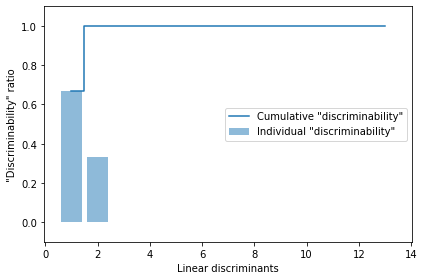

In [23]:
# 선형 판별 벡터 그리기
tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [24]:
# 변환 행렬 만들기
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))
print('행렬 W:\n', w)

행렬 W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


### 5.2.5 새로운 특성 공간으로 샘플 투영

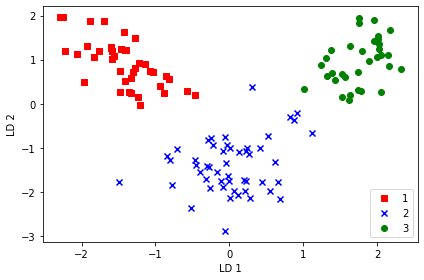

In [25]:
# 변환 행렬 곱해서 데이터 변환하기
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], 
                X_train_lda[y_train==l, 1] * (-1),
                c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 5.2.6 사이킷런의 LDA


In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

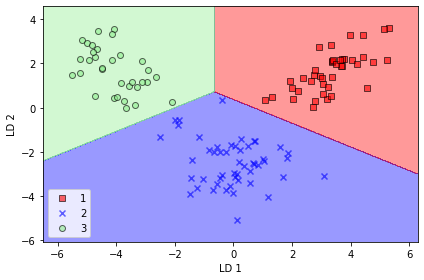

In [27]:
lr = LogisticRegression(random_state=1)
lr = lr.fit(X_train_lda, y_train)
pltreg.plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

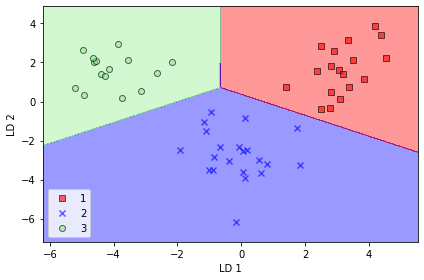

In [28]:
X_test_lda = lda.transform(X_test_std)
pltreg.plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [29]:
# 실제 사이킷런의 LDA 구현
y_uniq, y_count = np.unique(y_train, return_counts=True)
priors = y_count / X_train_std.shape[0]
priors

array([0.3306, 0.4032, 0.2661])

In [30]:
# 클래스 내 산포행렬
s_w = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, label in enumerate(y_uniq):
    s_w += priors[i] * np.cov(X_train_std[y_train==label].T, bias=True)

In [31]:
# 클래스 간 산포행렬
s_b = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train==i+1].shape[0]
    mean_vec = mean_vec.reshape(-1, 1)
    s_b += priors[i] * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

In [32]:
# 고유값 구하고 고유 벡터 정렬
import scipy
ei_val, ei_vec = scipy.linalg.eigh(s_b, s_w)
ei_vec = ei_vec[:, np.argsort(ei_val)[::-1]]

In [33]:
# scikit-learn 결과와 비교
lda_eigen = LDA(solver='eigen')
lda_eigen.fit(X_train_std, y_train)

LinearDiscriminantAnalysis(solver='eigen')

In [34]:
np.allclose(s_w, lda_eigen.covariance_)

True

In [35]:
# 클래스 간의 산포 행렬 = 총 산포 행렬 - 클래스 내 산포 행렬
Sb = np.cov(X_train_std.T, bias=True) - lda_eigen.covariance_
np.allclose(Sb, s_b)

True

In [36]:
# 고유벡터 비교
np.allclose(lda_eigen.scalings_[:, :2], ei_vec[:, :2])

True

In [37]:
np.allclose(lda_eigen.transform(X_test_std), np.dot(X_test_std, ei_vec[:, :2]))

True

## 5.3 커널 PCA를 사용하여 비선형 매핑

선형적으로 구분되지 않는 데이터를 선형 분류기에 적합한 새로운 저차원 부분 공간으로 변환하는 방법

### 5.3.1 커널 함수와 커널 트릭

커널 PCA를 통한 비선형 매핑을 수행하여 데이터를 고차원 공간으로 변환  
고차원 공간에 표준 PCA를 사용하여 샘플이 선형 분류기로 구분될 수 있는 저차원 공간으로 데이터를 투영  
하지만, 계산 비용이 매우 비싸다. -> 커널 트릭이 이용  
원본 특성 공간에서 두 고차원 특성 벡터의 유사도를 계산  

각각의 성분에 이미 투영된 샘플임  

RBF 커널 PCA를 구현하기 위해  
1) 커널 (유사도) 행렬 $\mathbf{K}$를 계산, 샘플의 모든 쌍에 대해 구함
2) 커널 행렬 $\mathbf{K}$를 중앙에 맞춤
3) 고유값 크기대로 내림차순으로 정렬하여 중앙에 맞춘 커널 행렬에서 최상위 $k$개의 고유 벡터를 고름

NOTE: 너무 어렵고 이해가 안 간다.  

### 5.3.2 파이썬으로 커널 PCA 구현

NOTE: goto /python_ML/kernel_PCA.py

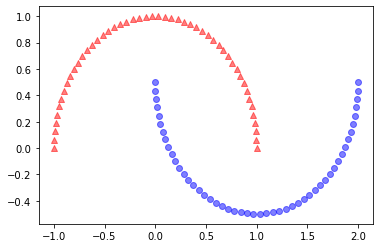

In [38]:
# 예제 1: 반달 모양 구분하기
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1],
            color='blue', marker='o', alpha=0.5)
plt.show()

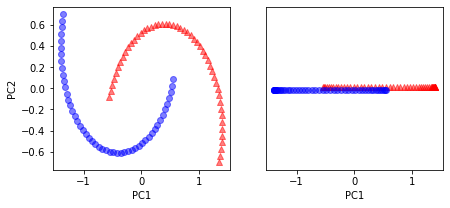

In [39]:
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((50, 1))+0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50, 1))-0.02,
              color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()


**선형적으로 구분 불가**

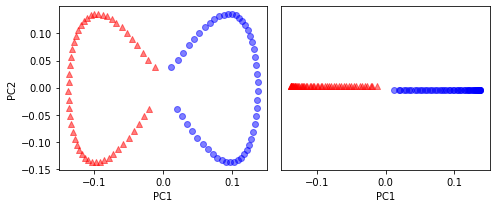

In [41]:
import kernel_PCA as kp

X_kpca = kp.rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
              color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

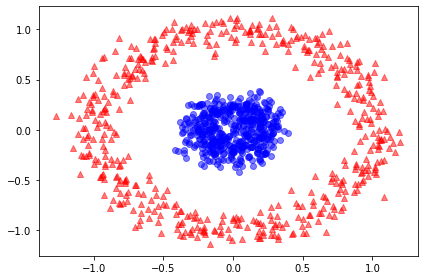

In [42]:
# 예제 2: 동심원 분리하기
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000,
                    random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1],
            color='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

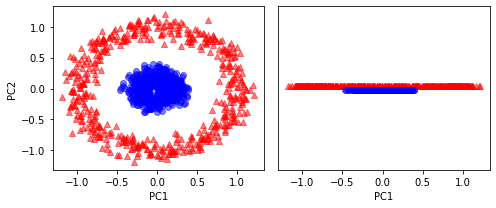

In [43]:
# 기본 PCA를 적용
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((500, 1))+0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500, 1))-0.02,
              color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

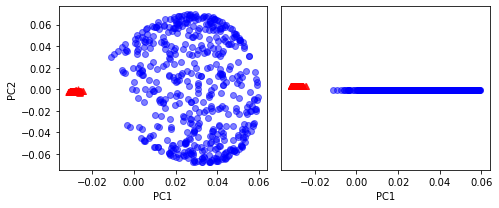

In [44]:
# 커널 PCA를 구현
X_kpca = kp.rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500, 1))+0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500, 1))-0.02,
              color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

### 5.3.3 새로운 데이터 포인트 투영

샘플은 이미 주성분 축 $\boldsymbol\nu$에 투영되어 있음  
훈련 데이터셋에 있는 $i$번째 샘플과 새로운 샘플 $\boldsymbol{x}'$사이 유사도를 계산  
고유값으로 고유 벡터 $\boldsymbol{a}$를 정규화

NOTE: /python_ML/kernel_PCA.py: 고유 벡터/고유값을 따로 출력하도록 수정

In [57]:
from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF 커널 PCA 구현
    
    매개변수
    ----------
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
    
    gamma: float
        RBF 커널 튜닝 매개변수
        
    n_components: int
        반환할 주성분 개수
        
    반환값
    ----------
    alphas: {넘파이 ndarray}, shape = [n_samples, k_features]
        투영된 데이터셋
        
    lambdas: list
        
    """
    # M * N 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산
    sq_dists = pdist(X, 'sqeuclidean')
    
    # 샘플 간의 거리를 정방 대칭 행렬로 변환
    mat_sq_dists = squareform(sq_dists)
    
    # 커널 행렬을 계산
    K = exp(-gamma * mat_sq_dists)
    
    # 커널 행렬을 중앙에 맞춤
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # 중앙에 맞춰진 커널 행렬의 고유값과 고유 벡터를 구함
    # scipy.linalg.eigh 함수는 오름차순으로 반환됨
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    # 최상위 k개의 고유 벡터를 선택 (투영 결과)
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])
    
    # 고유 벡터에 상응하는 고유값을 선택
    lambdas = [eigvals[i] for i in range(n_components)]
    
    return alphas, lambdas


In [58]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [59]:
# 26번을 새 데이터 포인트라고 가정
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [60]:
x_proj = alphas[25]
x_proj

array([0.0788])

In [61]:
# 위의 투영 함수로 새로 만들기
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum(
        (x_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)


In [63]:
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj

array([0.0788])

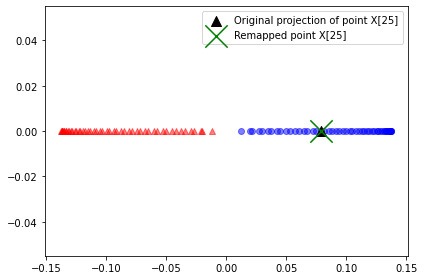

In [64]:
# 그래프로 그려 보기
plt.scatter(alphas[y==0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='Original projection of point X[25]',
            marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='Remapped point X[25]',
            marker='x', s=500)
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()

### 5.3.4 사이킷런의 커널 PCA

`sklearn.decomposition` 모듈의 `KernelPCA` 클래스 이용

In [65]:
from sklearn.decomposition import KernelPCA
X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, 
                        kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

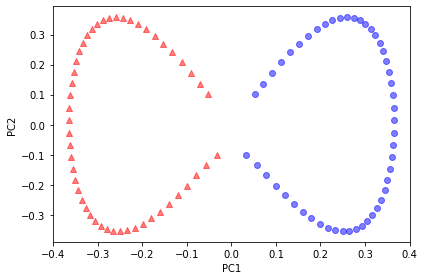

In [66]:
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

#### Reference: 매니폴드 알고리즘 적용해 보기


In [68]:
def plot_manifold(X, y):
    plt.scatter(X[y==0, 0], X[y==0, 1],
            color='red', marker='^', alpha=0.5)
    plt.scatter(X[y==1, 0], X[y==1, 1],
            color='blue', marker='o', alpha=0.5)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()

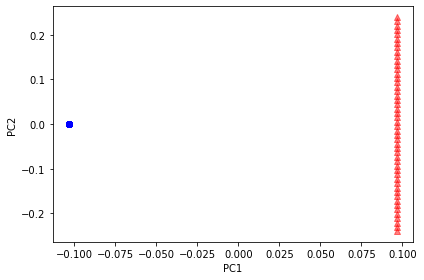

In [69]:
# LLE - locally linear embedding 이웃한 샘플 간의 거리를 유지하는 저차원 투영을 찾음
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, random_state=1)
X_lle = lle.fit_transform(X)
plot_manifold(X_lle, y)

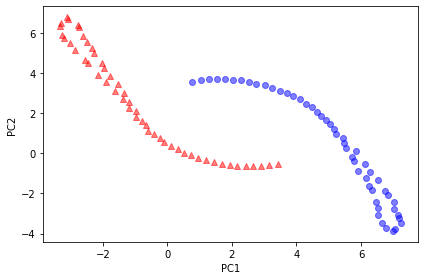

In [70]:
# t-SNE 데이터 포인트 간의 유사도를 결합 확률로 변환
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)
plot_manifold(X_tsne, y)

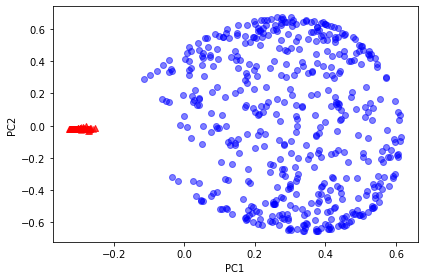

In [71]:
# 동심원 데이터셋을 다시 생성하고,
# KernelPCA 적용하기
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)
plot_manifold(X_skernpca, y)

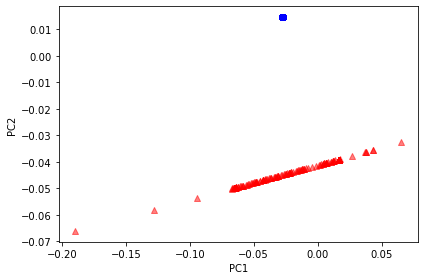

In [72]:
# LLE에 적용
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, random_state=1)
X_lle = lle.fit_transform(X)
plot_manifold(X_lle, y)

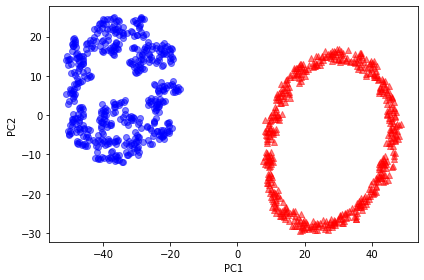

In [73]:
# t-SNE에 적용
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)
plot_manifold(X_tsne, y)

## 5.4 요약
